### Load Data (S&P 500 Stocks)

In [236]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# Folder with all S&P500 Stocks (Current Holdings -> Survivorship Bias possible)
folder = r"C:\Users\6eggr\Desktop\Python\New folder\daily_data"

tickers = [f[:-4] for f in os.listdir(folder) if f.endswith(".csv")]

dfs = {}

for ticker in tickers:
    file_path = os.path.join(folder, f"{ticker}.csv")
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading {ticker}: {e}")
        continue

    # Strip extra date info (e.g. exact time)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'].astype(str).str.slice(0, 10), errors='coerce')
    else:
        print(f"No 'Date' column found in {ticker}. Skipping.")
        continue

    required_cols = {'Date', 'Open', 'High', 'Low', 'Close'}
    if not required_cols.issubset(df.columns):
        print(f"Missing columns in {ticker}. Skipping.")
        continue

    df.set_index('Date', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close']].sort_index()

    dfs[ticker] = df

# Concatenate all DataFrames
combined_df = pd.concat(dfs, axis=1)

# Sort the combined DataFrame by date index
combined_df.sort_index(inplace=True)

# Convert wide format to long format
long_df = combined_df.stack(level=0).reset_index()

long_df.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close']

long_df =(long_df[long_df['Date']>'2000-01-01']).copy()

(long_df.head(5))



Missing columns in AAPL_features. Skipping.


,Date,Ticker,Open,High,Low,Close
1476466,2000-01-03,A,47.54,47.65,40.67,43.46
1476467,2000-01-03,AAPL,0.79,0.85,0.77,0.84
1476468,2000-01-03,ABT,8.35,8.52,8.23,8.29
1476469,2000-01-03,ACGL,1.34,1.35,1.20,1.22
1476470,2000-01-03,ADBE,16.69,16.76,15.95,16.27


### Create Features

In [322]:
import numpy as np
import pandas_ta as ta

def create_features(df):
    df = df.sort_values('Date')

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # Bollinger Bands + BB Width
    df['20_MA'] = df['Close'].rolling(window=20).mean()
    df['20_STD'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_MA'] + (1.5 * df['20_STD'])
    df['Lower_Band'] = df['20_MA'] - (1.5 * df['20_STD'])
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['Close']

    # Body Size + Relative Body Size
    period = 5
    df['Range'] = df['High'] - df['Low']  # Calculate range
    df['Range'].replace(0, np.nan, inplace=True)  # Replace zeros in the range with NaN
    df['BodySize'] = (df['Close'] - df['Open']) / df['Range']

    # Percent Change for short and long periods + Crossover
    short_period = 5
    long_period = 10
    df['Short_Change'] = df['Close'].pct_change(periods=short_period) * 100  # Look backward
    df['Long_Change'] = df['Close'].pct_change(periods=long_period) * 100  # Look backward
    df['Crossover'] = np.where(df['Short_Change'] > df['Long_Change'], 1, -1)

    # Moving Averages and EMAs
    df['5_EMA'] = ta.ema(df['Close'], length=5)
    df['10_MA'] = df['Close'].rolling(window=10).mean()
    df['20_MA'] = df['Close'].rolling(window=20).mean()  # Recalculate if not already defined
    df['50_MA'] = df['Close'].rolling(window=50).mean()

    # Drop intermediate columns
    df.drop(columns=['Range'], inplace=True)

    # Add percentage change over the past 1, 3, 6, and 12 months
    month_periods = {'1_Month': 21, '3_Months': 63, '6_Months': 126, '12_Months': 252}
    for label, period in month_periods.items():
        df[f'Pct_Change_{label}'] = df['Close'].pct_change(periods=period) * 100

    return df


In [324]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
long_df_features = long_df.groupby('Ticker', group_keys=False).apply(create_features)
long_df_features.dropna().head()

,Date,Ticker,Open,High,Low,Close,RSI,20_MA,20_STD,Upper_Band,Lower_Band,BB_Width,BodySize,Short_Change,Long_Change,Crossover,5_EMA,10_MA,50_MA,Pct_Change_1_Month,Pct_Change_3_Months,Pct_Change_6_Months,Pct_Change_12_Months,Target
1566395,2001-01-02,A,32.52,32.52,29.62,30.71,45.15,33.32,1.62,35.75,30.88,0.16,-0.62,-6.97,-10.55,1,32.31,32.78,30.21,-2.51,0.62,-30.96,-29.34,1
1566396,2001-01-02,AAPL,0.22,0.23,0.22,0.22,39.77,0.22,0.01,0.24,0.21,0.16,0.00,-0.83,5.78,-1,0.22,0.22,0.26,-9.85,-38.66,-72.10,-73.42,1
1566397,2001-01-02,ABT,11.61,11.85,11.58,11.61,42.45,11.97,0.47,12.68,11.26,0.12,0.00,1.58,2.80,-1,11.66,11.72,12.38,-12.60,0.78,9.51,40.03,-1
1566398,2001-01-02,ACGL,1.57,1.57,1.53,1.53,42.72,1.56,0.02,1.58,1.54,0.03,-1.00,-1.69,-2.93,1,1.55,1.56,1.59,-3.33,-7.94,-2.93,26.09,-1
1566399,2001-01-02,ADBE,29.01,29.07,22.24,23.22,33.75,31.85,3.26,36.74,26.97,0.42,-0.85,-28.84,-25.13,-1,28.17,30.22,35.05,-26.24,-42.64,-26.88,42.68,1


### Create Binary Features

###### The theory behind the coding of the indicators is essentially anti mean reversion. For example, my observation is that when people say stocks are overbought based on a high RSI, they continue to go up significantly. This is more so true for volatile stocks or periods, and much less so for value type stocks so model performance is expected to reflect that.

In [325]:
def create_binary_features(df):
    df = df.copy()

    df['BodySize'] = np.where(df['BodySize'] > 0.5, 1,
                              np.where(df['BodySize'] < (-0.5), -1, 0))    
    df['RSI_Signal'] = np.where(df['RSI'] > 70, 1,
                                np.where(df['RSI'] < 30, -1, 0))
    df['Gap'] = np.where(df['Close'].pct_change(periods=1).fillna(0) > 0, 1, -1)
    df['Outside_Band'] = np.where(df['Close'] > df['Upper_Band'], 1,
                                  np.where(df['Close'] < df['Lower_Band'], -1, 0))
    df['Short_Change'] = np.where(df['Short_Change'] > 0, 1, -1)
    df['Long_Change'] = np.where(df['Long_Change'] > 0, 1, -1)
    df['Pct_Change_3_Months'] = np.where(df['Pct_Change_3_Months'] > 0, 1, -1)
    df['Pct_Change_1_Month'] = np.where(df['Pct_Change_1_Month'] > 0, 1, -1)
    df['Pct_Change_6_Months'] = np.where(df['Pct_Change_6_Months'] > 0, 1, -1)
    df['Pct_Change_12_Months'] = np.where(df['Pct_Change_12_Months'] > 0, 1, -1)

    # EMA and SMA slopes
    df['5_EMA_Slope'] = np.where(df['5_EMA'].diff().fillna(0) > 0, 1, -1)
    df['10_SMA_Slope'] = np.where(df['10_MA'].diff().fillna(0) > 0, 1, -1)
    df['50_SMA_Slope'] = np.where(df['50_MA'].diff().fillna(0) > 0, 1, -1)
    df['20_MA_Slope'] = np.where(df['20_MA'].diff().fillna(0) > 0, 1, -1)


    # Binary variables for price relative to SMAs
    df['Above_10_SMA'] = np.where(df['Close'] > df['10_MA'], 1, -1)
    df['Above_20_SMA'] = np.where(df['Close'] > df['20_MA'], 1, -1)
    df['Above_50_SMA'] = np.where(df['Close'] > df['50_MA'], 1, -1)

    # Binary columns
    binary_columns = ['BodySize', '20_MA_Slope', 'RSI_Signal', 'Gap', 'Outside_Band',
                      'Short_Change', 'Long_Change', 'Pct_Change_3_Months',
                      'Pct_Change_1_Month', 'Pct_Change_6_Months', 'Pct_Change_12_Months',
                      '5_EMA_Slope', '10_SMA_Slope', '50_SMA_Slope', 'Above_10_SMA',
                      'Above_20_SMA', 'Above_50_SMA']

    df['Vote_Count'] = df[binary_columns].sum(axis=1)

    columns_to_keep = ['Date', 'Target', 'Ticker', 'Close'] + binary_columns + ['Vote_Count']

    return df[columns_to_keep]


In [ ]:
# Apply binary feature creation
binary_df = long_df_features.groupby('Ticker').apply(create_binary_features).reset_index(drop=True)
binary_df.head(20)

In [328]:
#Visualize features for a single stock
aapl_df = binary_df[binary_df['Ticker'] == 'AAPL']
aapl_df.head()

,Date,Target,Ticker,Close,BodySize,20_MA_Slope,RSI_Signal,Gap,Outside_Band,Short_Change,Long_Change,Pct_Change_3_Months,Pct_Change_1_Month,Pct_Change_6_Months,Pct_Change_12_Months,5_EMA_Slope,10_SMA_Slope,50_SMA_Slope,Above_10_SMA,Above_20_SMA,Above_50_SMA,Vote_Count
6283,2000-01-03,-1,AAPL,0.84,1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-13
6284,2000-01-04,1,AAPL,0.77,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-15
6285,2000-01-05,-1,AAPL,0.78,0,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-12
6286,2000-01-06,1,AAPL,0.72,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-15
6287,2000-01-07,-1,AAPL,0.75,1,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-11


In [329]:
# There are 17 features. We require 14 votes for a long (-14 to short), 
# then use a trailing vote system updated daily to hold positions or close
# when the # of votes falls below. The thresholds become one set of parameters. Turning
# this into a machine learning problem would mean testing out different combinations
# of features (and their parameters). Doing this for a single stock/market would clearly
# overfit the data, but a general model trained across stocks should theoretically be robust.

open_threshold = 14
close_threshold = 10

def simulate_trading(df):
    df = df.sort_values("Date").copy()
    
    # Initialize new columns
    df["Trade_Activity"] = "None"
    df["Daily_Return"] = 0.0
    df["Cumulative_Return"] = 1.0  
    
    # Track the current position state: "None", "Long", or "Short"
    position = "None"
    entry_price = None
    cumulative_return = 1.0  # Ongoing cumulative return

    for i in range(len(df)):
        vote = df.loc[df.index[i], "Vote_Count"]
        
        # Store the position status at the start of the day
        position_start_of_day = position

        # No position: decide whether to open a new one at today's close
        if position == "None":
            if vote >= open_threshold:
                position = "Long"
                entry_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Long"
            elif vote <= -open_threshold:
                position = "Short"
                entry_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Short"
            else:
                df.at[df.index[i], "Trade_Activity"] = "None"

        # Long position: decide whether to hold or close it at today's close
        elif position == "Long":
            if vote >= close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Long"
            else:
                # Close long position at today's close
                exit_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Long"
                position = "None"
                entry_price = None

        # Short position: decide whether to hold or close it at today's close
        elif position == "Short":
            if vote <= -close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Short"
            else:
                # Close short position at today's close
                exit_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Short"
                position = "None"
                entry_price = None

        # Calculate daily return based on the position held from yesterday
        if i > 0:
            if position_start_of_day == "Long":
                # If holding long from yesterday, compute return for today
                daily_ret = (df.loc[df.index[i], "Close"] / df.loc[df.index[i - 1], "Close"]) - 1
            elif position_start_of_day == "Short":
                # If holding short from yesterday, compute return for today
                daily_ret = (df.loc[df.index[i - 1], "Close"] / df.loc[df.index[i], "Close"]) - 1
            else:
                daily_ret = 0.0
            df.at[df.index[i], "Daily_Return"] = daily_ret
            # Update cumulative return only if there's a position from yesterday
            cumulative_return *= (1 + daily_ret)
        else:
            # First day: no previous day to compare, so daily return is 0
            df.at[df.index[i], "Daily_Return"] = 0.0

        # Store the updated cumulative return
        df.at[df.index[i], "Cumulative_Return"] = cumulative_return

    # if a position remains open, close it at the last available price
    if position != "None" and entry_price is not None:
        final_price = df.iloc[-1]["Close"]
        if position == "Long":
            # Realize returns from closing a long position
            # Note: No additional daily return is added since closure happens at simulation end
            cumulative_return *= final_price / entry_price
            df.at[df.index[-1], "Trade_Activity"] = "Close_Long_End"
        elif position == "Short":
            # Realize returns from closing a short position
            cumulative_return *= entry_price / final_price
            df.at[df.index[-1], "Trade_Activity"] = "Close_Short_End"
        df.at[df.index[-1], "Cumulative_Return"] = cumulative_return

    return df[["Date", "Ticker", "Close", "Vote_Count", "Trade_Activity", "Daily_Return", "Cumulative_Return"]]


In [330]:
trades_df = binary_df.groupby('Ticker').apply(simulate_trading)
trades_df.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

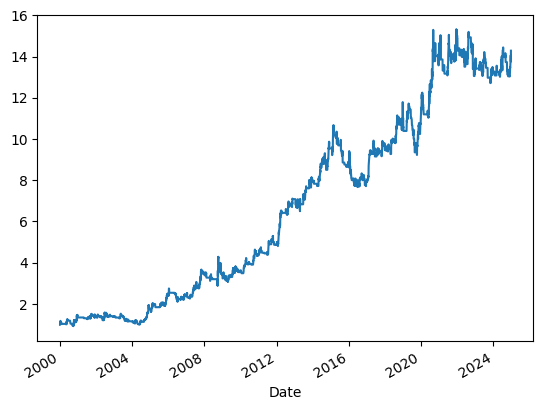

In [359]:
trades_df[trades_df['Ticker'] == 'AAPL'].head(40)

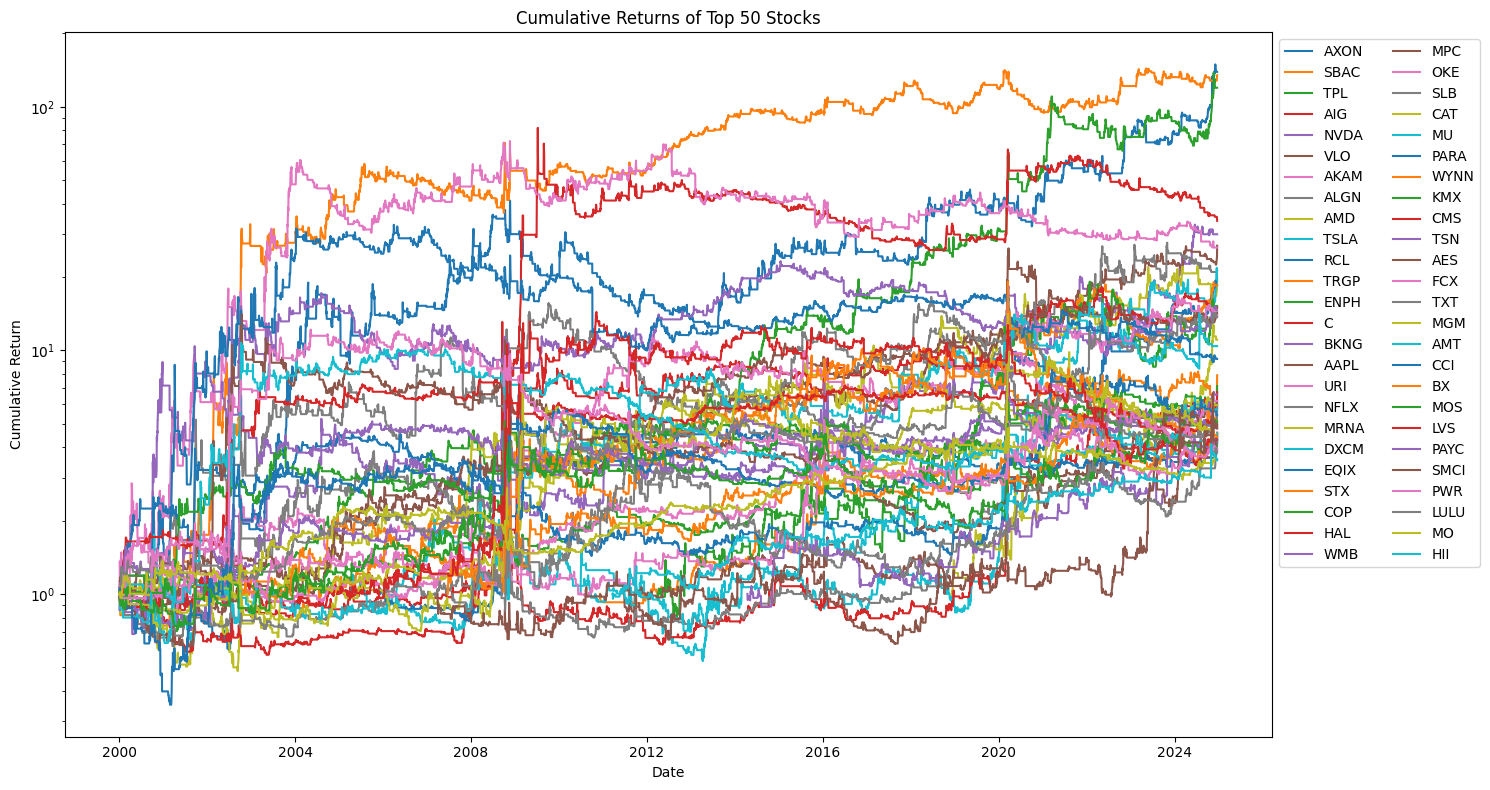

In [343]:
import matplotlib.pyplot as plt

# Group by Ticker and get the final cumulative return for each stock
final_cumulative_returns = trades_df.groupby('Ticker').last()['Cumulative_Return']

# Sort by cumulative return in descending order and get the top 50 stocks
top_50_tickers = final_cumulative_returns.sort_values(ascending=False).head(50).index

# Filter trades_df to include only the top 50 tickers
top_50_trades = trades_df[trades_df['Ticker'].isin(top_50_tickers)]

# Plot cumulative returns for the top 50 stocks
plt.figure(figsize=(15, 8))
for ticker in top_50_tickers:
    stock_data = top_50_trades[top_50_trades['Ticker'] == ticker]
    plt.plot(stock_data['Cumulative_Return'], label=ticker)

# Add labels and legend
plt.title('Cumulative Returns of Top 50 Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.yscale('log')
plt.tight_layout()
plt.show()


### Now an Ensemble of (Random) Models

In [366]:
import random

def generate_model_votes(df, num_models, num_indicators, model_threshold):
    #Generate votes from randomly selected sets of indicators with an integer threshold
    indicators = [col for col in df.columns if col not in ["Date", "Target", "Ticker", "Close", "Vote_Count"]]
    model_votes = []
    
    for i in range(num_models):
        selected_indicators = random.sample(indicators, num_indicators)
        # Count positive and negative contributions from selected indicators
        df[f"Model_Vote_{i}"] = df[selected_indicators].sum(axis=1).apply(
            lambda x: 1 if x >= model_threshold else (-1 if x <= -model_threshold else 0)
        )
        model_votes.append(f"Model_Vote_{i}")
    
    # Aggregate all model votes into a final vote count
    df["Vote_Count"] = df[model_votes].sum(axis=1)
    return df


def simulate_trading_with_models(df, num_models, num_indicators, open_threshold, close_threshold, model_threshold):
    # Generate model votes and aggregate
    df = generate_model_votes(df, num_models, num_indicators, model_threshold)
    
    # Sort DataFrame chronologically
    df = df.sort_values("Date").copy()

    # Initialize new columns
    df["Trade_Activity"] = "None"
    df["Daily_Return"] = 0.0
    df["Cumulative_Return"] = 1.0  

    # Track the current position 
    position = "None"
    entry_price = None
    cumulative_return = 1.0  

    for i in range(len(df)):
        vote = df.loc[df.index[i], "Vote_Count"]
        
        # Store the position status 
        position_start_of_day = position

        # No position: decide whether to open a new one 
        if position == "None":
            if vote >= open_threshold:
                position = "Long"
                entry_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Long"
            elif vote <= -open_threshold:
                position = "Short"
                entry_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Short"
            else:
                df.at[df.index[i], "Trade_Activity"] = "None"

        # Long position: decide whether to hold or close it at today's close
        elif position == "Long":
            if vote >= close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Long"
            else:
                # Close long position at today's close
                exit_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Long"
                position = "None"
                entry_price = None

        # Short position: decide whether to hold or close it at today's close
        elif position == "Short":
            if vote <= -close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Short"
            else:
                # Close short position at today's close
                exit_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Short"
                position = "None"
                entry_price = None

        # Calculate daily return based on the position held from yesterday
        if i > 0:
            if position_start_of_day == "Long":
                # If holding long from yesterday, compute return for today
                daily_ret = (df.loc[df.index[i], "Close"] / df.loc[df.index[i - 1], "Close"]) - 1
            elif position_start_of_day == "Short":
                # If holding short from yesterday, compute return for today
                daily_ret = (df.loc[df.index[i - 1], "Close"] / df.loc[df.index[i], "Close"]) - 1
            else:
                daily_ret = 0.0
            df.at[df.index[i], "Daily_Return"] = daily_ret
            # Update cumulative return only if there's a position from yesterday
            cumulative_return *= (1 + daily_ret)
        else:
            # First day so daily return is 0
            df.at[df.index[i], "Daily_Return"] = 0.0

        # Store the cumulative return
        df.at[df.index[i], "Cumulative_Return"] = cumulative_return

    # After loop: if a position remains open, close it at the last available price
    if position != "None" and entry_price is not None:
        final_price = df.iloc[-1]["Close"]
        if position == "Long":
            # Realize returns from closing a long position
            cumulative_return *= final_price / entry_price
            df.at[df.index[-1], "Trade_Activity"] = "Close_Long_End"
        elif position == "Short":
            # Realize returns from closing a short position
            cumulative_return *= entry_price / final_price
            df.at[df.index[-1], "Trade_Activity"] = "Close_Short_End"
        df.at[df.index[-1], "Cumulative_Return"] = cumulative_return

    return df[["Date", "Ticker", "Close", "Vote_Count", "Trade_Activity", "Daily_Return", "Cumulative_Return"]]



In [367]:
trades_df_ens = binary_df.groupby('Ticker').apply(
    lambda group: simulate_trading_with_models(
        group, 
        num_models=50, 
        num_indicators=10, 
        open_threshold=45, 
        close_threshold=40,
        model_threshold=5  # Minimum 3 votes needed for a signal
    )
)
trades_df_ens.set_index('Date', inplace=True)


In [379]:
trades_df_ens[trades_df['Ticker'] == 'PYPL'].head(15)

,Ticker,Close,Vote_Count,Trade_Activity,Daily_Return,Cumulative_Return,Return
Date,,,,,,,
2015-07-06,PYPL,36.71,-50,Open_Short,0.00,1.00,NaN
2015-07-07,PYPL,36.62,-50,Hold_Short,0.00,1.00,0.00
2015-07-08,PYPL,34.70,-50,Hold_Short,0.06,1.06,0.06
2015-07-09,PYPL,34.50,-50,Hold_Short,0.01,1.06,0.01
2015-07-10,PYPL,34.69,-50,Hold_Short,-0.01,1.06,-0.01
2015-07-13,PYPL,36.78,-18,Close_Short,-0.06,1.00,-0.06
2015-07-14,PYPL,36.93,-21,None,0.00,1.00,0.00
2015-07-15,PYPL,37.51,-21,None,0.00,1.00,0.00
2015-07-16,PYPL,38.63,-21,None,0.00,1.00,0.00


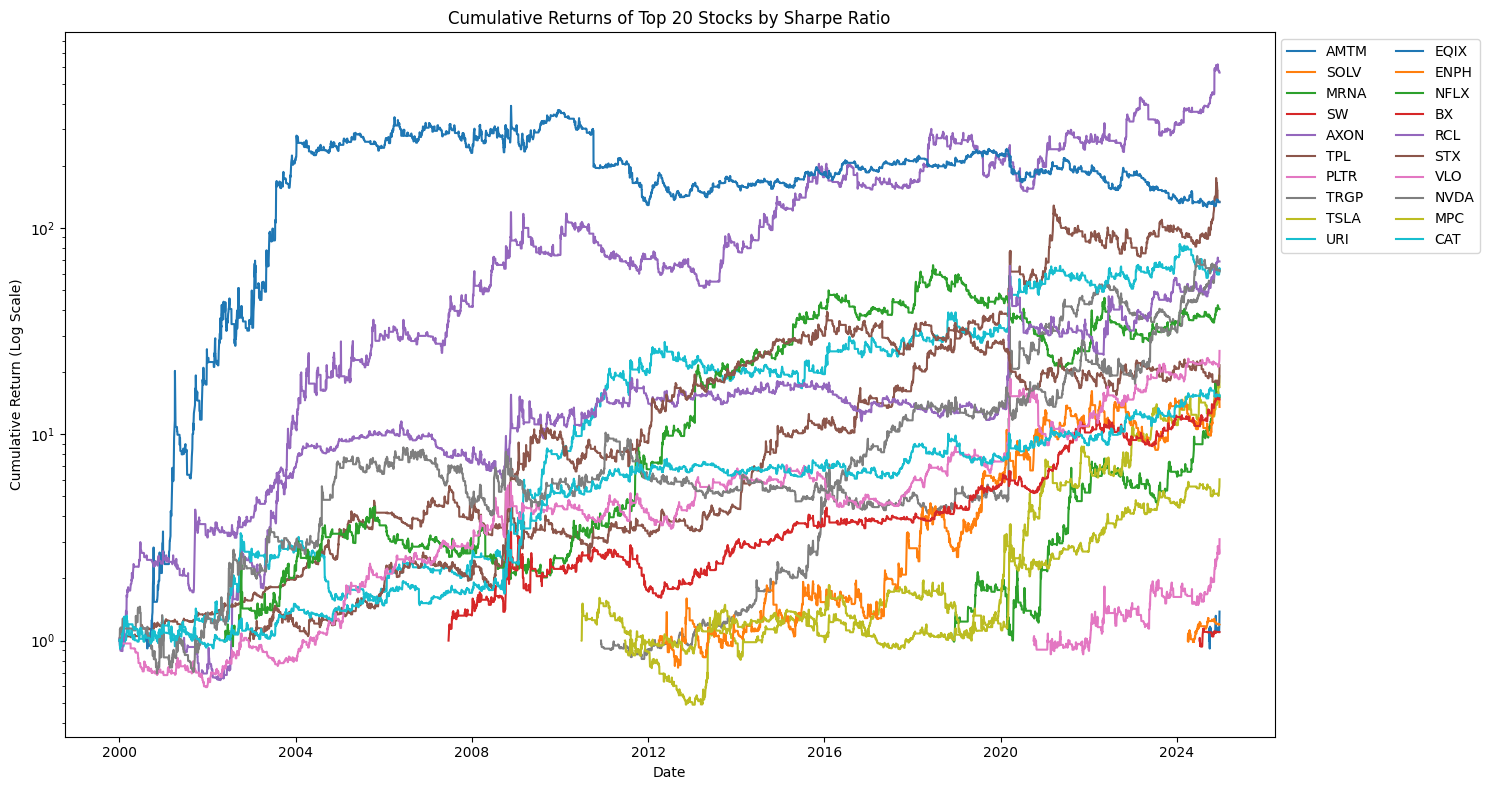

In [374]:
# Calculate the daily returns
trades_df_ens['Return'] = trades_df_ens.groupby('Ticker')['Cumulative_Return'].pct_change()

# Calculate the Sharpe ratio for each stock 
sharpe_ratios = trades_df_ens.groupby('Ticker')['Return'].mean() / trades_df_ens.groupby('Ticker')['Return'].std()

# Sort by Sharpe ratio get the top 50 stocks
top_sharpe_tickers = sharpe_ratios.sort_values(ascending=False).head(20).index

# Filter trades_df to include only the top Sharpe ratio tickers
top_sharpe_trades = trades_df_ens[trades_df_ens['Ticker'].isin(top_sharpe_tickers)]

# Plot cumulative returns for the top Sharpe ratio stocks
plt.figure(figsize=(15, 8))
for ticker in top_sharpe_tickers:
    stock_data = top_sharpe_trades[top_sharpe_trades['Ticker'] == ticker]
    plt.plot(stock_data['Cumulative_Return'], label=ticker)

plt.yscale('log')
plt.title('Cumulative Returns of Top 20 Stocks by Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Log Scale)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.tight_layout()
plt.show()


###### The takeaway from above is that the models are still trading too much, but given that the baseline/non trained models CAN provide some signal, it is possible that well parameterized models could be valuable. My belief is that with the right framework, as # of trades goes down, winrate should go up. When we have thousands of markets to trade it makes sense to only trade those that currently have the highest probability of success. The goal of the features (and thresholding) was to restrict the model to only trade in optimal conditions, but the # of trades being placed suggests it fails to be restrictive enough. Theoretically, if we can find sets of highly profitable conditions that only happen 1 or 2 times a year on average per stock for example, we can scale those across 1,000+ stocks. Low frequency of signals in such an approach could be a significant edge as most people are trying to maximize the # of signals (for psychological reasons, e.g. overtrading and wanting to be able to predict every single move, as well as for statistical significance). This is where ML and a significant amount of compute could be very valuable.